<a href="https://colab.research.google.com/github/awaaat/Machine_learning-Deep_learning/blob/main/CNN_ComputerVission_Image_Classificstion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial shows how to classify images of flowers using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. It demonstrates the following concepts:

Efficiently loading a dataset off disk.
Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.
This tutorial follows a basic machine learning workflow:

Examine and understand data
Build an input pipeline
Build the model
Train the model
Test the model
Improve the model and repeat the process
In addition, the notebook demonstrates how to convert a saved model to a TensorFlow Lite model for on-device machine learning on mobile, embedded, and IoT devices.

#Set up: Importing the needed modules and libraries
"""

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import keras
from tensorflow.keras.models import Sequential
from PIL import Image
from IPython.display import display
from IPython.display import display, HTML
import io
import base64
import sys
from os import listdir
import pathlib

"""#We have the following classes of images
##flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [3]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos.tar',
                                   dataset_url,
                                   untar=True,
                                   extract = True,
                                   cache_dir = '.',
                                   cache_subdir = '')
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)



228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
3670


In [4]:
listdir(data_dir)

['LICENSE.txt', 'tulips', 'sunflowers', 'dandelion', 'roses', 'daisy']

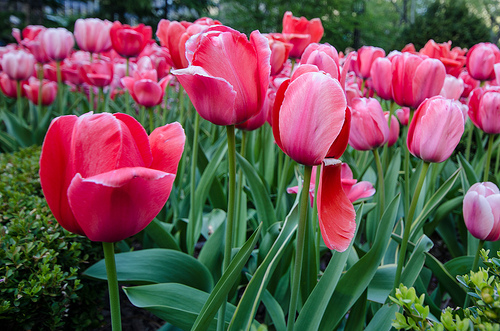

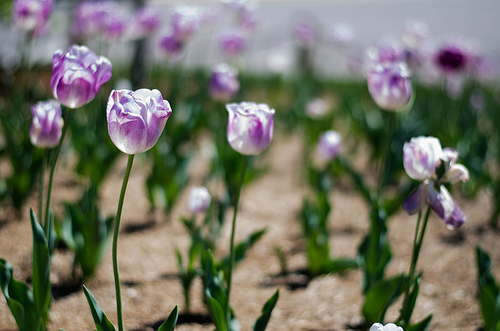

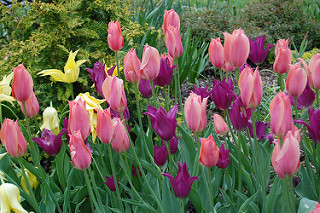

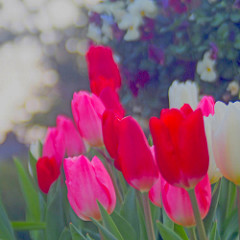

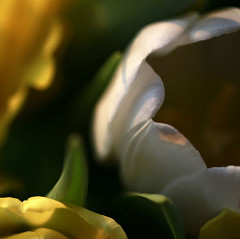

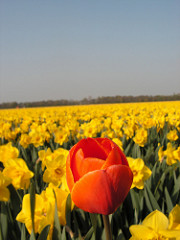

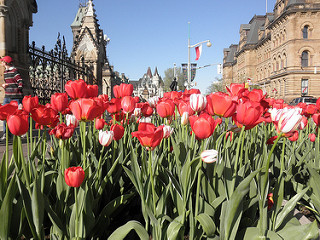

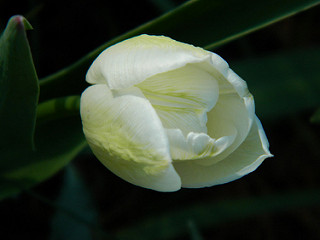

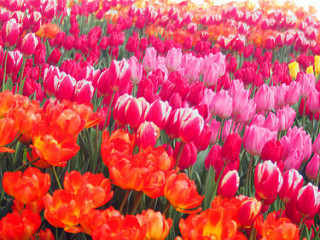

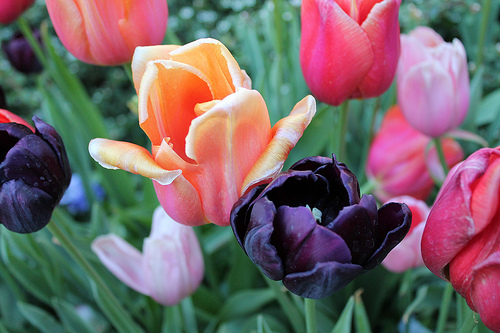

In [5]:
tulips = list(data_dir.glob('tulips/*'))  # Get all rose image paths
for i in range(10):
    img = Image.open(str(tulips[i]))
    display(img)

#Load data using a Keras utility

In [6]:
batch_size = 32
image_height = 180
image_width=180

#Fetch the training set
training_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size = batch_size,
    image_size = (image_height, image_width),
    seed = 123,
    validation_split = 0.2,
    subset = 'training',

)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
#Fetch the validation set
validation_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size = batch_size,
    image_size = (image_height, image_width),
    validation_split = 0.2,
    subset = 'validation',
    seed=123
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = training_data.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_data = validation_set.cache().prefetch(buffer_size = AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255.0)

In [10]:
class_names = training_data.class_names
number_of_classes = len(class_names)
print(number_of_classes)

5


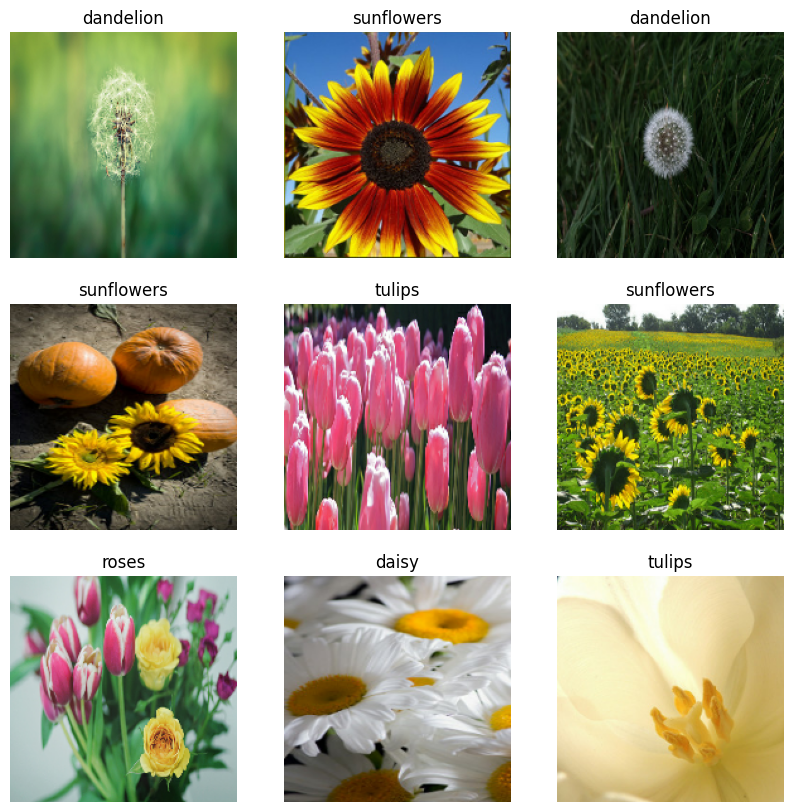

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Model Definition

In [12]:

model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_of_classes)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [14]:

epochs=10
history  = model.fit(
  training_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.3886 - loss: 1.4868 - val_accuracy: 0.5954 - val_loss: 1.0382
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6291 - loss: 0.9619 - val_accuracy: 0.6253 - val_loss: 0.9959
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6968 - loss: 0.8191 - val_accuracy: 0.6553 - val_loss: 0.8496
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.7908 - loss: 0.5774 - val_accuracy: 0.6281 - val_loss: 0.9428
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8663 - loss: 0.3836 - val_accuracy: 0.6035 - val_loss: 1.1983
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9326 - loss: 0.1984 - val_accuracy: 0.6253 - val_loss: 1.2259
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9554 - loss: 0.1309 - val_accuracy: 0.6226 - val_loss: 1.4733
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9838 - loss: 0.0608 - val_accuracy: 0.6485 - v

#Visualizing the Training Results

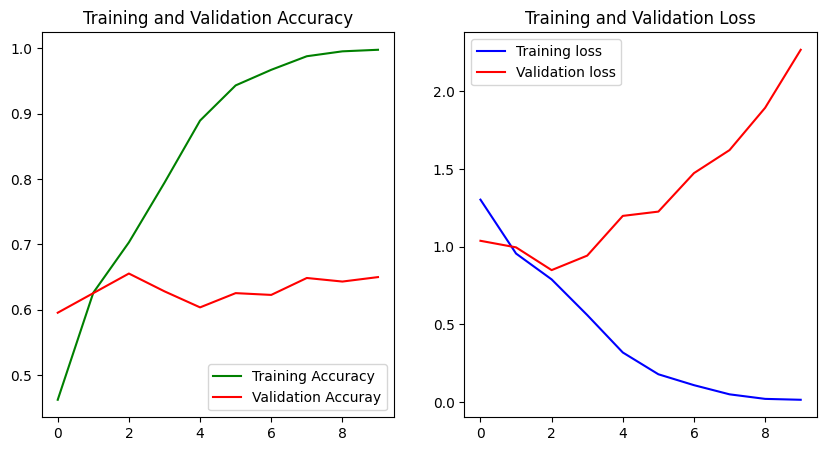

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = epochs
def plot_evaluations(acc, val_acc, loss, val_loss):
  epoch_range = range(epochs)
  plt.figure(figsize = (10, 5))
  plt.subplot(1,2,1)
  plt.plot(epoch_range, acc, label = 'Training Accuracy', c = 'g')
  plt.plot(epoch_range, val_acc, label = 'Validation Accuray', c = 'r')
  plt.legend(loc = 'lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1,2,2)
  plt.plot(epoch_range, loss, label = 'Training loss', c = 'b')
  plt.plot(epoch_range, val_loss, label = 'Validation loss', c = 'r')
  plt.legend(loc = 'upper left')
  plt.title('Training and Validation Loss')
  plt.show()


plot_evaluations(acc, val_acc, loss, val_loss)

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

The above demonistrates overfitting and we have to mitigate it.

#Overfitting

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your mode

#Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [38]:
data_augmentation_layer = tf.keras.Sequential(
    [
        layers.RandomFlip('Horiizontal', input_shape = (image_height, image_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


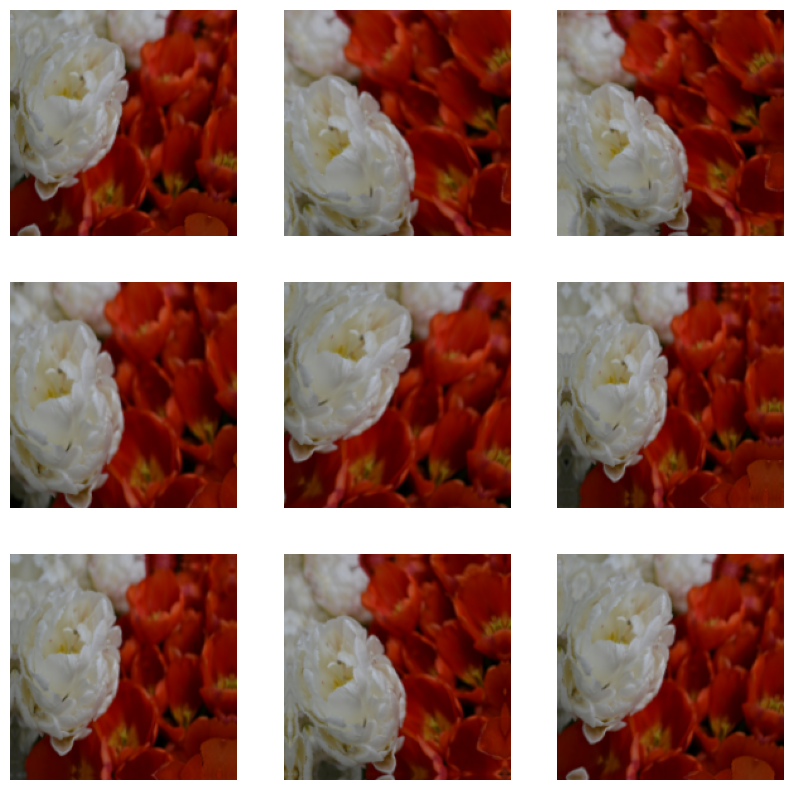

In [39]:
#We can view  few of teh augmented image examples
def view_augmented_images():
  plt.figure(figsize = (10, 10))
  for images, _ in training_data.take(1):
    for i in range(9):
      augmented_images = data_augmentation_layer(images)
      ax = plt.subplot(3,3, i+1)
      plt.imshow(augmented_images[0].numpy().astype('uint8'))
      plt.axis('off')


view_augmented_images()


We will be adding data augmentation to your model before training in the next step.

#Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [40]:

model_1 = Sequential([
  data_augmentation_layer,
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_of_classes, name = 'outputs')
])

model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs = 15
history = model_1.fit(
  training_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4065 - loss: 1.3985 - val_accuracy: 0.5640 - val_loss: 1.0763
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6072 - loss: 0.9985 - val_accuracy: 0.6022 - val_loss: 0.9852
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6442 - loss: 0.9105 - val_accuracy: 0.5858 - val_loss: 1.0531
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6841 - loss: 0.8355 - val_accuracy: 0.6553 - val_loss: 0.9044
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7231 - loss: 0.7455 - val_accuracy: 0.6921 - val_loss: 0.7964
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7364 - loss: 0.7031 - val_accuracy: 0.6826 - val_loss: 0.8117
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7397 - loss: 0.6762 - val_accuracy: 0.7057 - val_loss: 0.8063
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7608 - loss: 0.6033 - val_accuracy: 0.6907 - v

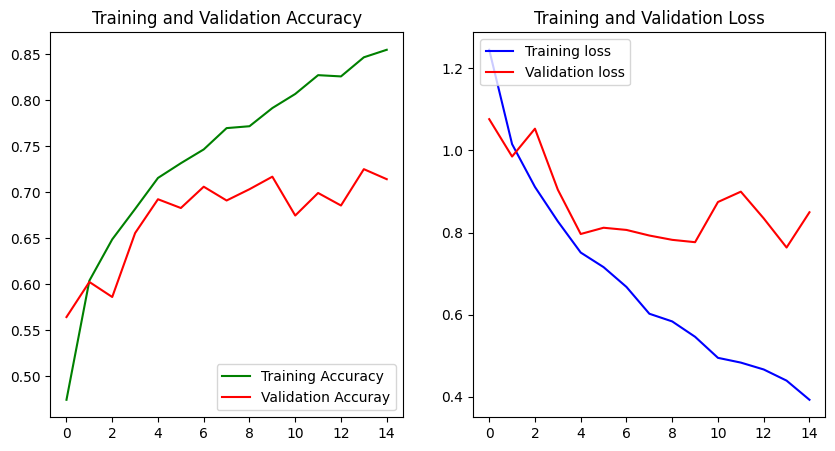

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plot_evaluations(acc, val_acc, loss, val_loss)

#Predict on new useen data
Use your model to classify an image that wasn't included in the training or validation sets.

In [75]:
flower_url= 'https://media.istockphoto.com/id/1807846109/photo/pink-roses.jpg?s=1024x1024&w=is&k=20&c=gGVGEu3xJWTdmYcdB6nVs3S0kZ5erru-lnFgNZuc_XI='
flower_path = tf.keras.utils.get_file('flo', origin = flower_url)

96208/96208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [76]:
img_to_classify = tf.keras.utils.load_img(flower_path, target_size=(180, 180))
image_array  = tf.keras.utils.img_to_array(img_to_classify)
image_array = tf.expand_dims(image_array, 0)
image_pred = model_1.predict(image_array)
score = tf.nn.softmax(image_pred[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image most likely belongs to tulips with a 51.49 percent confidence.


#Use TensorFlow Lite

Convert the Keras Sequential model to a TensorFlow Lite model
To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

In this example, take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model:

In [60]:
#Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tfliteModel = converter.convert()
#save the model
with open('model.tflite', 'wb') as f:
  f.write(tfliteModel)



Saved artifact at '/tmp/tmpso4hnxer'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132261658114912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261658114032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261658110160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729925984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729917536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729917184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729913312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729701904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729707888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132261729704368: TensorSpec(shape=(), dtype=tf.resource, name=None)


#Run the TensorFlow Lite model
You can access the TensorFlow Lite saved model signatures in Python via the tf.lite.Interpreter class.

Load the model with the Interpreter:

In [61]:
tf_model_path = 'model.tflite'
interpreter = tf.lite.Interpreter(model_path = tf_model_path)
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_45'], 'outputs': ['output_0']}}

#Now you can test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows:


In [62]:
classifier = interpreter.get_signature_runner('serving_default')
classifier

In [63]:
preds = classifier(keras_tensor_45 = image_array)['output_0']
sccore = tf.nn.softmax(preds)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 96.34 percent confidence.


In [64]:
print(np.max(np.abs(preds- image_pred)))

2.3841858e-06


#Here is the Model Pipeline

In [88]:
import os
save_dir = 'saved_models/'
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, 'classifier_weights.weights.h5')

model_1.save_weights(weights_path)

print(f"Weights saved to {weights_path}")


Weights saved to saved_models/classifier_weights.weights.h5


In [93]:
weights_path = 'saved_models/classifier_weights.weights.h5'
classifier= model_1

# Load the weights into the classifier model
weights = classifier.load_weights(weights_path)

print("Weights loaded successfully from", weights_path)


Weights loaded successfully from saved_models/classifier_weights.weights.h5


In [98]:
class imageClassifier:
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names

    def load_user_image_details(self):
        image_name = input('Enter the name of your image here: ')
        image_url = input('Enter the URL of your image here: ')
        image_path = tf.keras.utils.get_file(image_name, origin=image_url)
        return image_path

    def extract_and_preprocess_image(self, image_path):
        classification_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        classification_image_array = tf.keras.utils.img_to_array(classification_image)
        classification_image_array = tf.expand_dims(classification_image_array, 0)
        return classification_image_array

    def classify_image(self):
        image_path = self.load_user_image_details()
        preprocessed_image = self.extract_and_preprocess_image(image_path)
        classification_image_pred = self.model.predict(preprocessed_image)
        classification_score = tf.nn.softmax(classification_image_pred[0])
        print(
            "This image most likely belongs to '{}' with a {:.2f} percent confidence."
            .format(self.class_names[np.argmax(classification_score)], 100 * np.max(classification_score))
        )


classifier = imageClassifier(model=model_1, class_names=class_names)

# Classify the image based on user input
classifier.classify_image()


Enter the name of your image here: rose
Enter the URL of your image here: https://upload.wikimedia.org/wikipedia/commons/8/8b/Rose_flower.jpg
201040/201040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
This image most likely belongs to 'roses' with a 61.24 percent confidence.


In [100]:
!pip install flask
!pip install pyngrok

In [103]:
!ngrok authtoken 2laPv1fI3CpQpwgABw3NgBewRYh_4fuxLCBonQCP7v5DRt1dE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [114]:
import tensorflow as tf
import numpy as np
from flask import Flask, render_template_string, request
from pyngrok import ngrok

app = Flask(__name__)

class imageClassifier:
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names

    def load_user_image_details(self, image_name, image_url):
        image_path = tf.keras.utils.get_file(image_name, origin=image_url)
        return image_path

    def extract_and_preprocess_image(self, image_path):
        classification_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        classification_image_array = tf.keras.utils.img_to_array(classification_image)
        classification_image_array = tf.expand_dims(classification_image_array, 0)
        return classification_image_array

    def classify_image(self, image_name, image_url):
        image_path = self.load_user_image_details(image_name, image_url)
        preprocessed_image = self.extract_and_preprocess_image(image_path)
        classification_image_pred = self.model.predict(preprocessed_image)
        classification_score = tf.nn.softmax(classification_image_pred[0])
        predicted_class = self.class_names[np.argmax(classification_score)]
        confidence = 100 * np.max(classification_score)
        return predicted_class, confidence

# Assuming model_1 and class_names are predefined
classifier = imageClassifier(model=model_1, class_names=class_names)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        image_name = request.form['image_name']
        image_url = request.form['image_url']
        predicted_class, confidence = classifier.classify_image(image_name, image_url)
        return render_template_string('''
            <!DOCTYPE html>
            <html lang="en">
            <head>
                <meta charset="UTF-8">
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
                <title>Classification Result</title>
                <style>
                    body {font-family: Arial, sans-serif; background-color: #f4f4f4; color: #333; margin: 0; padding: 0;}
                    .container {max-width: 600px; margin: 50px auto; padding: 20px; background-color: #fff; border-radius: 8px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);}
                    h1 {text-align: center; color: #333;}
                    p {text-align: center;}
                    a {display: block; text-align: center; margin-top: 20px; color: #007bff; text-decoration: none;}
                    a:hover {text-decoration: underline;}
                </style>
            </head>
            <body>
                <div class="container">
                    <h1>Classification Result</h1>
                    <p>The image <strong>{{ image_name }}</strong> most likely belongs to <strong>{{ predicted_class }}</strong> with a confidence of <strong>{{ confidence }}%</strong>.</p>
                    <a href="/">Classify Another Image</a>
                </div>
            </body>
            </html>
        ''', image_name=image_name, predicted_class=predicted_class, confidence=confidence)

    return render_template_string('''
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Image Classifier</title>
            <style>
                body {font-family: Arial, sans-serif; background-color: #f4f4f4; color: #333; margin: 0; padding: 0;}
                .container {max-width: 600px; margin: 50px auto; padding: 20px; background-color: #fff; border-radius: 8px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);}
                h1 {text-align: center; color: #333;}
                form {display: flex; flex-direction: column;}
                label {margin-bottom: 5px; color: #666;}
                input[type="text"] {padding: 10px; margin-bottom: 20px; border: 1px solid #ddd; border-radius: 4px;}
                button {padding: 10px; background-color: #28a745; color: #fff; border: none; border-radius: 4px; cursor: pointer;}
                button:hover {background-color: #218838;}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Image Classifier</h1>
                <form method="POST">
                    <label for="image_name">Image Name:</label>
                    <input type="text" id="image_name" name="image_name" required>
                    <label for="image_url">Image URL:</label>
                    <input type="text" id="image_url" name="image_url" required>
                    <button type="submit">Classify Image</button>
                </form>
            </div>
        </body>
        </html>
    ''')

# Open a tunnel to the Flask app using ngrok
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel available at {public_url}")

# Start the Flask app
app.run()


 * ngrok tunnel available at NgrokTunnel: "https://4b7a-34-74-135-143.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [04/Sep/2024 02:25:07] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [04/Sep/2024 02:25:07] "GET /favicon.ico HTTP/1.1" 404 -


143837/143837 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


INFO:werkzeug:127.0.0.1 - - [04/Sep/2024 02:26:28] "POST / HTTP/1.1" 200 -
